<a href="https://colab.research.google.com/github/ruizdiazji/MachineLearningUNS2022/blob/master/ml_clase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ejercicio 3.1
Supongamos que tenemos un dataset mezcla de dos grupos aleatorios bidimensionales (cada uno con 100 datos, su centroide y covariancia). Encontrar un clasificador por K-NN y evaluar exactitud, precisión, f-measure. Tomar inicialmente un dataset de entrenamiento de N=100 (50+50), k=10, y validar con el resto del dataset. Hacer algunos experimentos con otros N y k, y también cambiando centroide y covariancia de la clases. 

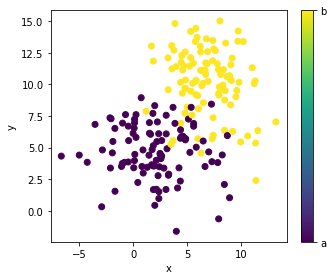

In [42]:
from scipy.stats import multivariate_normal
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

from google.colab import data_table
data_table.enable_dataframe_formatter()

def random_multi_normal(mean=None,cov=None, size = None):
  np.random.seed()
  if mean is None:
    mean = [np.random.randint(0, 15), np.random.randint(0,15)]
  if cov is None:
    cov = [[10, 0], [0, 10]]
    a_00 = np.random.randint(1,15)
    a_11 = np.random.randint(1,15)
    cov = [a_00,0],[0,a_11]
  try:
    x, y = np.random.default_rng().multivariate_normal(mean, cov, size).T
  except:
    if mean is not None:
      raise "Error, variable mean no es correcta"
    if cov is not None:
      raise "Error, variable cov no es correcta"
    if size is None or size.type is not int:
      raise "Error, size debe ser entero y mayor a cero"
  return x,y 


def generate_df(mean_1, cov_1, mean_2, cov_2, size = 50, plot_variables = False):
  x1,y1 = random_multi_normal(mean_1,cov_1,size)
  x2,y2 = random_multi_normal(mean_2,cov_2,size)
  
  label_a = np.full(size, 'a')
  target_a = np.full(size,0)
  df_a = pd.DataFrame(dict(a=label_a,x=x1, y=y1,target=target_a), columns=['a','x', 'y',"target"])
  label_b = np.full(size, 'b')
  target_b = np.full(size,1)
  df_b = pd.DataFrame(dict(b=label_b,x=x2, y=y2,target=target_b), columns=['b','x', 'y','target'])

  if (len(df_a) == len(df_b)):
    col_0 = np.append(df_a['a'], df_b['b'])
    col_1 = np.append(df_a['x'],df_b['x'])
    col_2 = np.append(df_a['y'],df_b['y'])
    col_3 = np.append(df_a['target'],df_b['target'])
    df = pd.DataFrame({'label':col_0,'x':col_1,'y':col_2,'target':col_3})
    df = shuffle(df)


  if plot_variables:
    x_index = 0
    y_index = 1
    target_names = ['a','b']
    # this formatter will label the colorbar with the correct target names
    formatter = plt.FuncFormatter(lambda i, *args: target_names[int(i)])

    plt.figure(figsize=(5, 4))
    plt.scatter(df['x'], df['y'], c=df.target)
    plt.colorbar(ticks=[0, 1], format=formatter)
    plt.xlabel("x")
    plt.ylabel("y")

    plt.tight_layout()
    plt.show()
  
  return df

df = generate_df([2,5],[[10,0],[0,5]],[7,10],[[7,0],[0,5]],100, True)

Para separar el conjunto de datos en mitad de entrenamiento y mitad de testeo, utilizamos train_test_split de scikit learn con el dataframe previamente aleatorizado.

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:3]], df.target, test_size=0.5, random_state=1) 

Utilizando la biblioteca neighbors de scikit learn implementamos el algoritmo de K Vecinos más cercanos (KNN en inglés) tomando como parámetro k=10 y sin "pesar" los puntos con algún criterio, es decir, con weight= uniforme.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


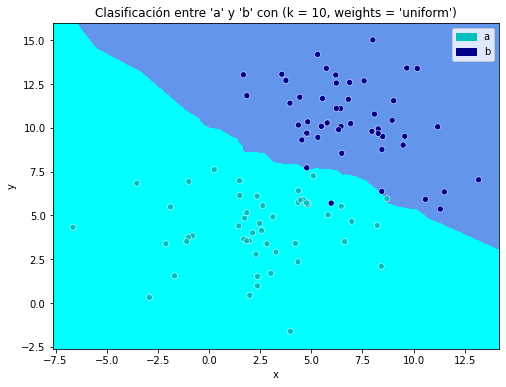

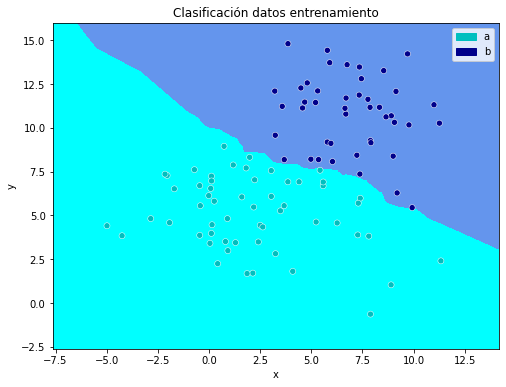

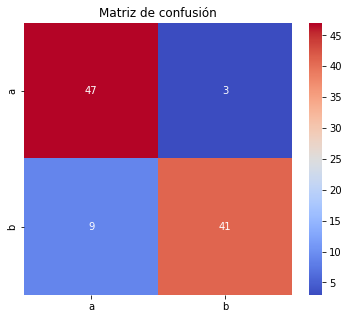

-----------------------------------------------------------------
TP: 47 	FP: 9 	TN: 41 	FN: 3
accuracy: 0.88
precision: 0.839
sensitivity: 0.94
specificity: 0.82
f_measure: 0.887
indice Jaccard: 0.797
-----------------------------------------------------------------


In [44]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

def get_knn(X_train, y_train, k,weights_list):
  h = 0.02  # step size in the mesh

  # Create color maps
  cmap_light = ListedColormap(["cyan", "cornflowerblue"])
  cmap_bold = ["c", "darkblue"]

  for weights in weights_list:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(k, weights=weights)
    clf.fit(X_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_train['x'].min() - 1, X_train['x'].max() + 1
    y_min, y_max = X_train['y'].min() - 1, X_train['y'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light,data=y_train)
    # Plot also the training points
    sns.scatterplot(
        x=X_train['x'],
        y=X_train['y'],
        hue=y_train,
        palette=cmap_bold,
        alpha=1.0,
        legend='full',
    )
    
    a_instance = mpatches.Patch(color="c", label='a')
    b_instance = mpatches.Patch(color="darkblue", label='b')
    plt.legend(handles=[a_instance, b_instance])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "Clasificación entre 'a' y 'b' con (k = %i, weights = '%s')" % (k, weights)
    )
    plt.xlabel('x')
    plt.ylabel('y')

  plt.show()
  return clf,xx,yy,Z

def get_predict(clf,X_test,xx,yy,Z):
    h = 0.02  # step size in the mesh
    # Create color maps
    cmap_light = ListedColormap(["cyan", "cornflowerblue"])
    cmap_bold = ["c", "darkblue"]

    y_predict = clf.predict(X_test)
    # Put the result into a color plot
    #y_predict = y_predict.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    sns.scatterplot(
        x=X_test['x'],
        y=X_test['y'],
        hue=y_predict,
        palette=cmap_bold,
        alpha=1.0,
        legend='full',
    )
    
    a_instance = mpatches.Patch(color="c", label='a')
    b_instance = mpatches.Patch(color="darkblue", label='b')
    plt.legend(handles=[a_instance, b_instance])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Clasificación datos entrenamiento")
    plt.xlabel('x')
    plt.ylabel('y')
    return y_predict

def get_confusion_matrix(y_test,y_pred,plot=True):
  matrix = confusion_matrix(y_test, y_pred)
  if plot:
    df = pd.DataFrame(matrix, index = [i for i in "ab"], columns = [i for i in "ab"])
    plt.figure(figsize = (6,5))
    sns.heatmap(df, annot=True,cmap="coolwarm")
    plt.title("Matriz de confusión")
    plt.show()
  return matrix

def get_model_params(matrix):
  tp, fn, fp, tn = matrix.flatten()
  return tp,fp,tn,fn
def get_accuracy(model_params):
  return (model_params[0]+model_params[2])/(model_params[0]+model_params[1]+model_params[2]+model_params[3])

def get_precision(model_params):
  return (model_params[0]/(model_params[0]+model_params[1]))

def get_sensitivity(model_params):
  return (model_params[0]/(model_params[0]+model_params[3]))

def get_f_measure(model_params):
  precision = get_precision(model_params)
  sensitivity = get_sensitivity(model_params)
  return (2*precision*sensitivity)/(precision+sensitivity)

def get_specificity(model_params):
  fpr = model_params[1] /(model_params[1]+model_params[2])
  return (1 - fpr)

def get_jaccard(model_params):
  return(model_params[0]/(model_params[0]+model_params[1]+model_params[3]))

def print_model_params(model_params):
  print("-----------------------------------------------------------------")
  print("TP:",model_params[0],"\tFP:",model_params[1],"\tTN:",model_params[2],"\tFN:",model_params[3])
  print("accuracy:", round(get_accuracy(model_params),3))
  print("precision:",round(get_precision(model_params),3))
  print("sensitivity:",round(get_sensitivity(model_params),3))
  print("specificity:",round(get_specificity(model_params),3))
  print("f_measure:",round(get_f_measure(model_params),3))
  print("indice Jaccard:",round(get_jaccard(model_params),3))
  print("-----------------------------------------------------------------")

knn_clas,xx,yy,Z = get_knn(X_train,y_train,10,["uniform"])
label_pred = get_predict(knn_clas,X_test,xx,yy,Z)
matriz_confusion=get_confusion_matrix(y_test,label_pred)

model_params = get_model_params(matriz_confusion)
print_model_params(model_params)


Tomando el mismo dataset y realizando el entrenamiento con KNN pero, en esta ocasión, ponderando cada punto según la inversa de su distancia. De este modo, puntos más cercanos tendran mayotr "peso" que los puntos más lejanos.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


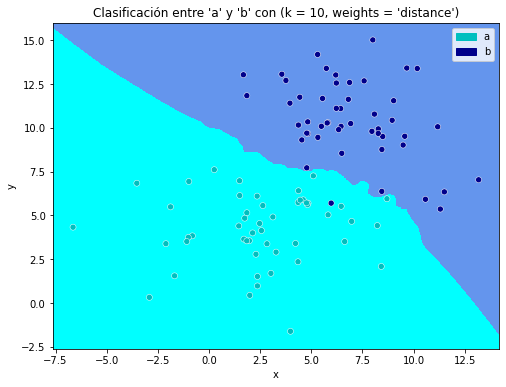

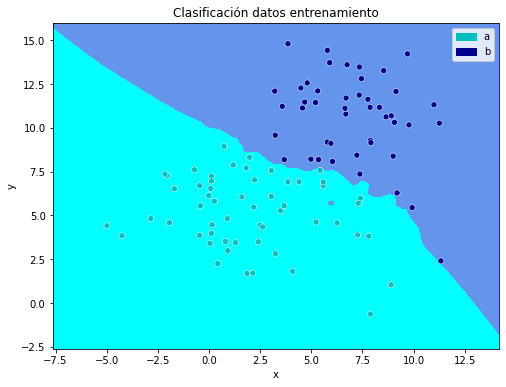

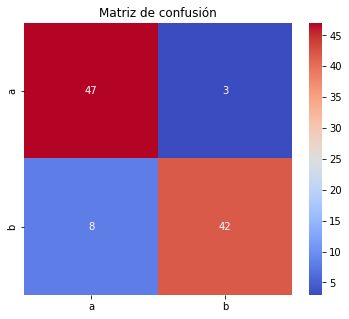

-----------------------------------------------------------------
TP: 47 	FP: 8 	TN: 42 	FN: 3
accuracy: 0.89
precision: 0.855
sensitivity: 0.94
specificity: 0.84
f_measure: 0.895
indice Jaccard: 0.81
-----------------------------------------------------------------


In [45]:
knn_clas,xx,yy,Z = get_knn(X_train,y_train,10,["distance"])
label_pred = get_predict(knn_clas,X_test,xx,yy,Z)
matriz_confusion=get_confusion_matrix(y_test,label_pred)

model_params = get_model_params(matriz_confusion)
print_model_params(model_params)

Al utilizar KNN ponderando cada punto por distancia vemos que el modelo sobreajusta, ya que no es capaz de generalizar.

Tomando el mismo dataset utilizado anteriormente, vamos a evaluar qué sucede si elegimos 3, 14(raíz cuadrada de doscientos), y 30 vecinos más cercanos.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


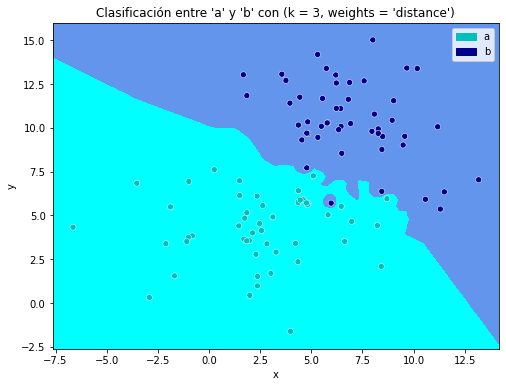

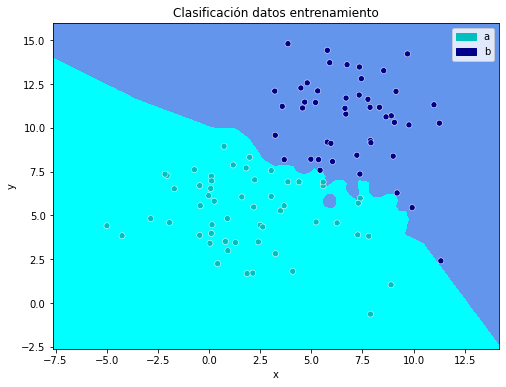

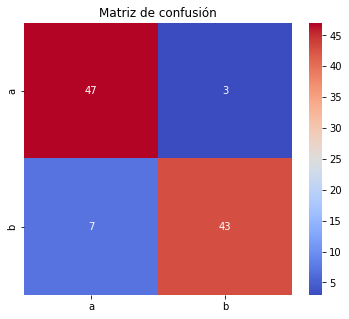

-----------------------------------------------------------------
TP: 47 	FP: 7 	TN: 43 	FN: 3
accuracy: 0.9
precision: 0.87
sensitivity: 0.94
specificity: 0.86
f_measure: 0.904
indice Jaccard: 0.825
-----------------------------------------------------------------


In [46]:
knn_clas,xx,yy,Z = get_knn(X_train,y_train,3,["distance"])
label_pred = get_predict(knn_clas,X_test,xx,yy,Z)
matriz_confusion=get_confusion_matrix(y_test,label_pred)

model_params = get_model_params(matriz_confusion)
print_model_params(model_params)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


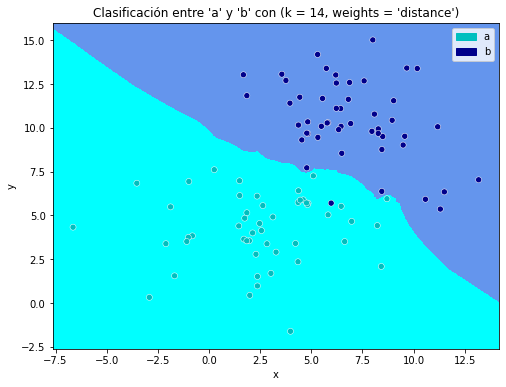

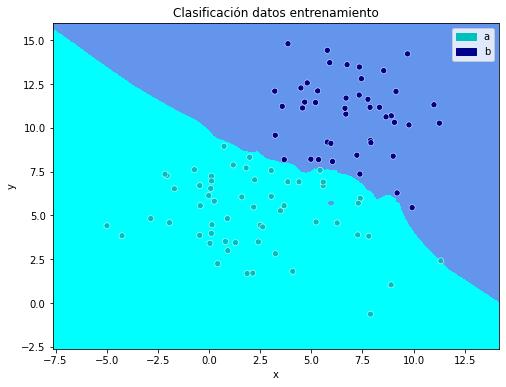

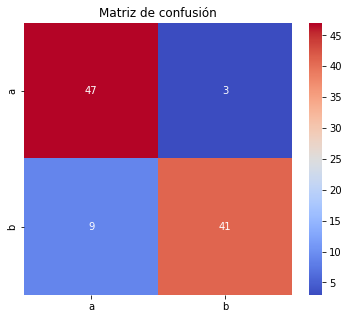

-----------------------------------------------------------------
TP: 47 	FP: 9 	TN: 41 	FN: 3
accuracy: 0.88
precision: 0.839
sensitivity: 0.94
specificity: 0.82
f_measure: 0.887
indice Jaccard: 0.797
-----------------------------------------------------------------


In [47]:
knn_clas,xx,yy,Z = get_knn(X_train,y_train,14,["distance"])
label_pred = get_predict(knn_clas,X_test,xx,yy,Z)
matriz_confusion=get_confusion_matrix(y_test,label_pred)

model_params = get_model_params(matriz_confusion)
print_model_params(model_params)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


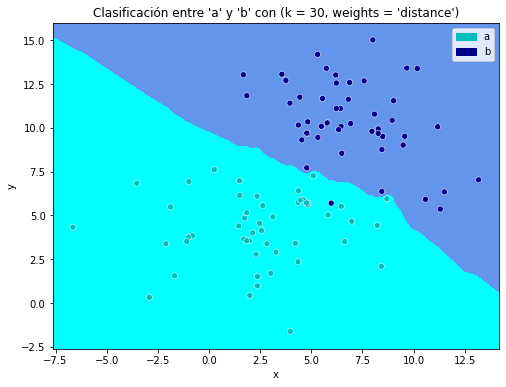

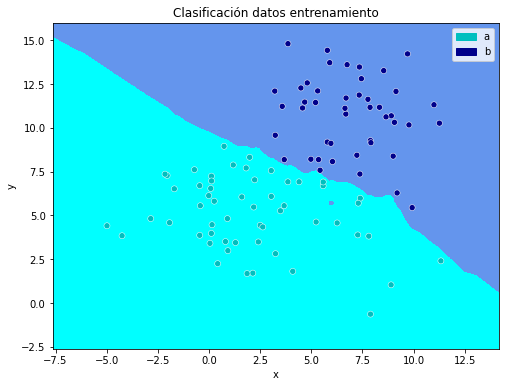

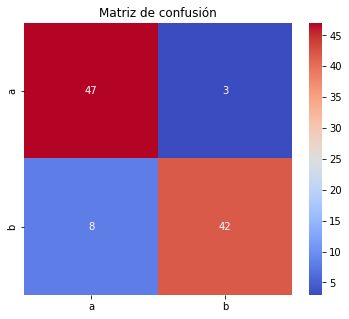

-----------------------------------------------------------------
TP: 47 	FP: 8 	TN: 42 	FN: 3
accuracy: 0.89
precision: 0.855
sensitivity: 0.94
specificity: 0.84
f_measure: 0.895
indice Jaccard: 0.81
-----------------------------------------------------------------


In [48]:
knn_clas,xx,yy,Z = get_knn(X_train,y_train,30,["distance"])
label_pred = get_predict(knn_clas,X_test,xx,yy,Z)
matriz_confusion=get_confusion_matrix(y_test,label_pred)

model_params = get_model_params(matriz_confusion)
print_model_params(model_params)

Podemos observar que, con k= 14 se obtienen los mejores valores para los parámetros de precisión, exactitud y f-measure.

#Ejercicio 3.2
Tomando el dataset anterior, vamos a experimentar utilizando gridsearch

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


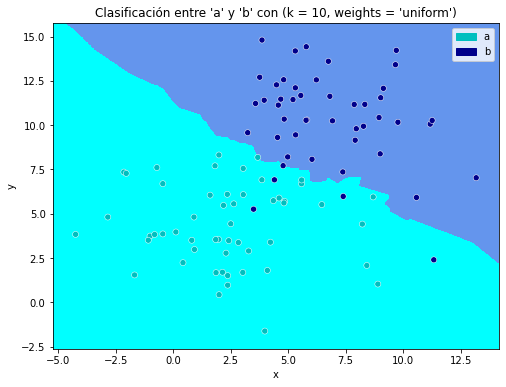

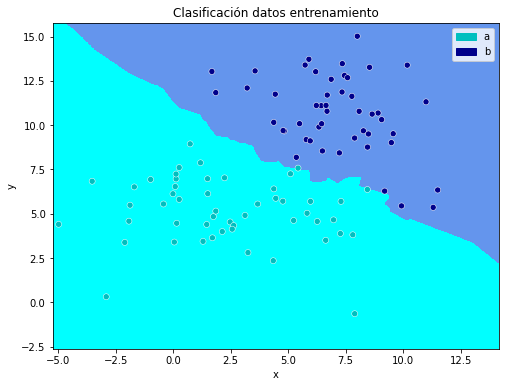

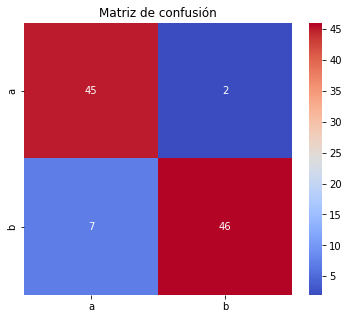

-----------------------------------------------------------------
TP: 45 	FP: 7 	TN: 46 	FN: 2
accuracy: 0.91
precision: 0.865
sensitivity: 0.957
specificity: 0.868
f_measure: 0.909
indice Jaccard: 0.833
-----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


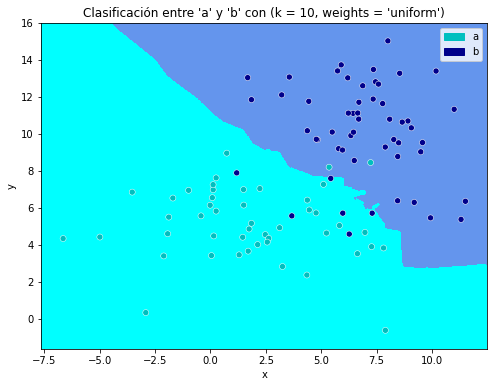

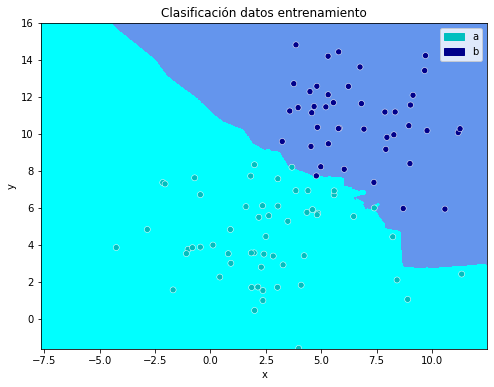

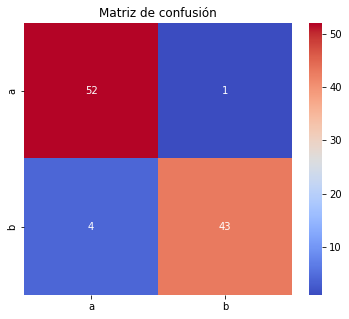

-----------------------------------------------------------------
TP: 52 	FP: 4 	TN: 43 	FN: 1
accuracy: 0.95
precision: 0.929
sensitivity: 0.981
specificity: 0.915
f_measure: 0.954
indice Jaccard: 0.912
-----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


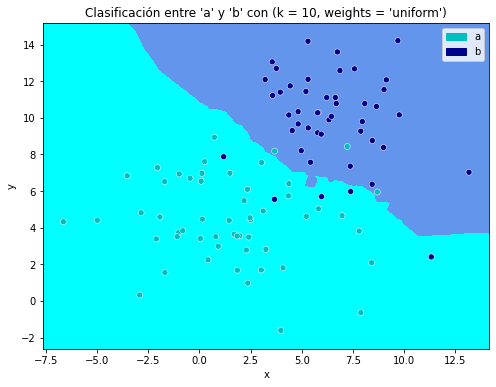

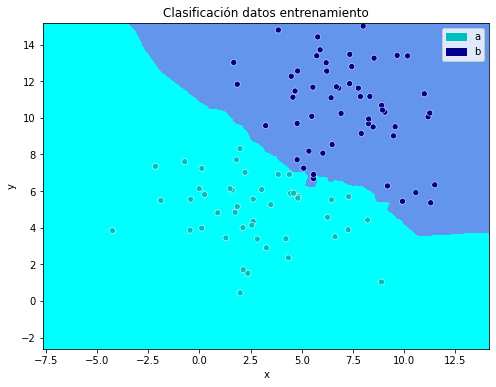

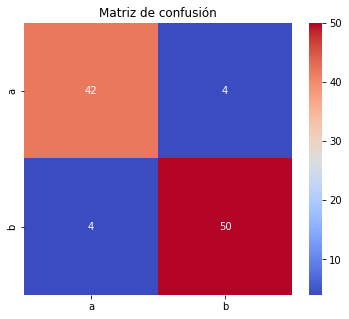

-----------------------------------------------------------------
TP: 42 	FP: 4 	TN: 50 	FN: 4
accuracy: 0.92
precision: 0.913
sensitivity: 0.913
specificity: 0.926
f_measure: 0.913
indice Jaccard: 0.84
-----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


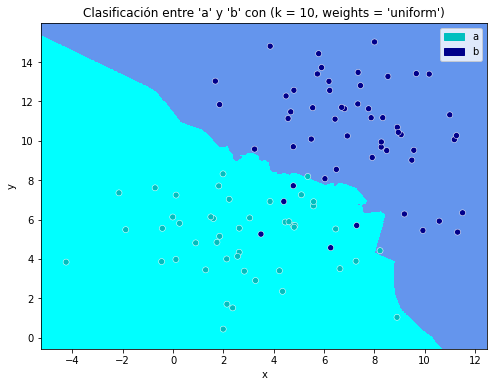

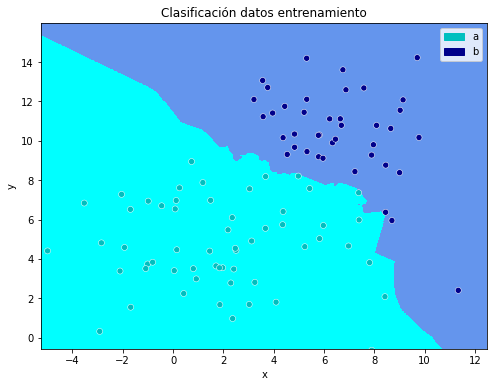

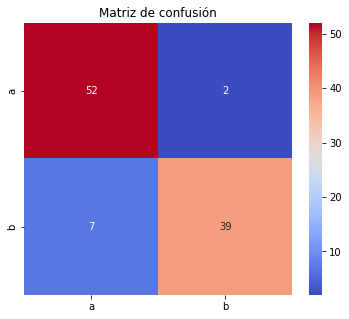

-----------------------------------------------------------------
TP: 52 	FP: 7 	TN: 39 	FN: 2
accuracy: 0.91
precision: 0.881
sensitivity: 0.963
specificity: 0.848
f_measure: 0.92
indice Jaccard: 0.852
-----------------------------------------------------------------
Clasificador  0
-----------------------------------------------------------------
TP: 45 	FP: 7 	TN: 46 	FN: 2
accuracy: 0.91
precision: 0.865
sensitivity: 0.957
specificity: 0.868
f_measure: 0.909
indice Jaccard: 0.833
-----------------------------------------------------------------
Clasificador  1
-----------------------------------------------------------------
TP: 52 	FP: 4 	TN: 43 	FN: 1
accuracy: 0.95
precision: 0.929
sensitivity: 0.981
specificity: 0.915
f_measure: 0.954
indice Jaccard: 0.912
-----------------------------------------------------------------
Clasificador  2
-----------------------------------------------------------------
TP: 42 	FP: 4 	TN: 50 	FN: 4
accuracy: 0.92
precision: 0.913
sensitivity: 0.9

In [49]:
from sklearn.model_selection import RepeatedKFold

X = df[df.columns[1:4]]
y = df[df.columns[3]]
random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
train_folds, test_folds = [],[]

for train, test in rkf.split(X):
  train_folds.append(train)
  test_folds.append(test)

models = []
if len(train_folds) == len(test_folds):
  for i in range(len(train_folds)):
    df_train = df.iloc[train_folds[i]]
    df_test = df.iloc[test_folds[i]]
    knn_clas,xx,yy,Z = get_knn(df_train[df_train.columns[1:3]],df_train.target,10,["uniform"])
    label_pred = get_predict(knn_clas,df_test[df_test.columns[1:3]],xx,yy,Z)
    matriz_confusion=get_confusion_matrix(df_test.target,label_pred)
    model_params = get_model_params(matriz_confusion)
    models.append({"knn":knn_clas,"matriz confusion":matriz_confusion,"params": model_params})
    print_model_params(model_params)

for i in range(len(models)):
  print("Clasificador ",(i))
  print_model_params(models[i]["params"])

Utilizando CrossFold validation se puede ver que, es posible obtener varios clasificadores diferentes y, entre ellos, seleccionar el más adecuado según la/s métricas que resulten importantes para el modelo, como por ejemplo, f-measure, índice de Jaccard, etc.

#Ejercicio 3.3
En el <a ref="https://github.com/manlio99/Materia-de-aprendizaje/blob/master/3_MidtermProjects/musica.ipynb">notebook</a> hay un dataset con más de 2000 canciones de Spotify de una usuaria, donde algunas fueron marcadas como gustadas y otras no. Cada canción tiene a su vez 16 atributos(nombre, artista, duración, bailable,etc.) Desarrollar un clasificador que prediga si una canción dada va a ser gustada o no. Aclarar y justificar los pasos, analizar y explicar los resultados.

In [50]:
import pandas as pd
#leemos el dataset
attributes_spotify = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")
attributes_spotify = attributes_spotify.drop(columns=["Unnamed: 0"])
attributes_spotify.head(2000)


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.02020,0.333,174240,0.913,0.000000,2,0.1460,-3.722,1,0.0808,99.889,4.0,0.129,0,Paris - Pegboard Nerds Remix,The Chainsmokers
1996,0.00363,0.743,259889,0.889,0.143000,10,0.3830,-5.567,1,0.0409,103.963,4.0,0.186,0,Quit You - Wuki Remix,Lost Kings
1997,0.00087,0.465,265600,0.953,0.014600,8,0.2260,-4.684,0,0.2950,160.064,4.0,0.554,0,Don't Let Me Down - Zomboy Remix,The Chainsmokers
1998,0.03160,0.680,211853,0.725,0.000018,6,0.1120,-3.920,1,0.0611,140.048,4.0,0.260,0,Faded - Slushii Remix,Alan Walker


Para clasificar las canciones utilizaremos, unicamente, los argumentos de la columna accousticness hasta valence, como variables de entrada. La variable target es la que queremos poder predecir con el clasificador y las variables song_title y artist no son relevantes para entrenar el algoritmo de clasificación. Además, para el entrenamiento de KNN usaremos CrossFold validation dividiendo el conjunto de datos, en principio, en 5 repeticiones de 5 grupos.

In [51]:
from numpy.ma.core import sqrt
X = attributes_spotify[attributes_spotify.columns[1:13]]
y = attributes_spotify[attributes_spotify.columns[13]]
k_list = list(range(1,int(np.sqrt(X.shape[0]))))
splits = 5


Debido a que el dataset de spotify tiene varios atributos que pueden o no ser normales, en primer instancia, graficaremos la distribución de cada una de las variables y, luego, para evitar que el modelo pueda ser sensible a la escala de los datos vamos a; Normalizar los datos que no sigan una distribución reconocible. Estandarizar aquellas variables que tengan una distribución normal.

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from random import randint


def plot_histograms(df = None, rows = None,columns = None,figWidth=10,figHeight=30,plot_log_normal = False):
  sns.color_palette("flare", as_cmap=True)

  f, axes = plt.subplots(rows,columns,figsize=(figWidth,figHeight), sharex=False)
  plt.subplots_adjust(hspace = 0.5)
  ind = 0
  axes = np.ravel(axes, order='F')
  colors = []
  
  for i in range(rows):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

  for f in df.columns:
    try:
      sns.histplot(df[f],ax=axes[ind], kde = True,color=colors[ind])
      sns.rugplot(df[f], color="red", ax=axes[ind])
      axes[ind].set_title("Histograma de "+f)
    except Exception as e:
      print("Error",e," graficando el histograma ",f)
    ind+=1
  if plot_log_normal:
    for f in df.columns:
      try:
        ind_color = ind - 9
        sns.histplot(df[f],ax=axes[ind], kde = True, color=colors[ind_color],log_scale = True)
        sns.rugplot(df[f], color="red", ax=axes[ind])
        axes[ind].set_title("Histograma de "+f+" aplicando el log")
      except Exception as e:
        print("Error",e," graficando el histograma ", f," aplicandole el log")
      ind+=1

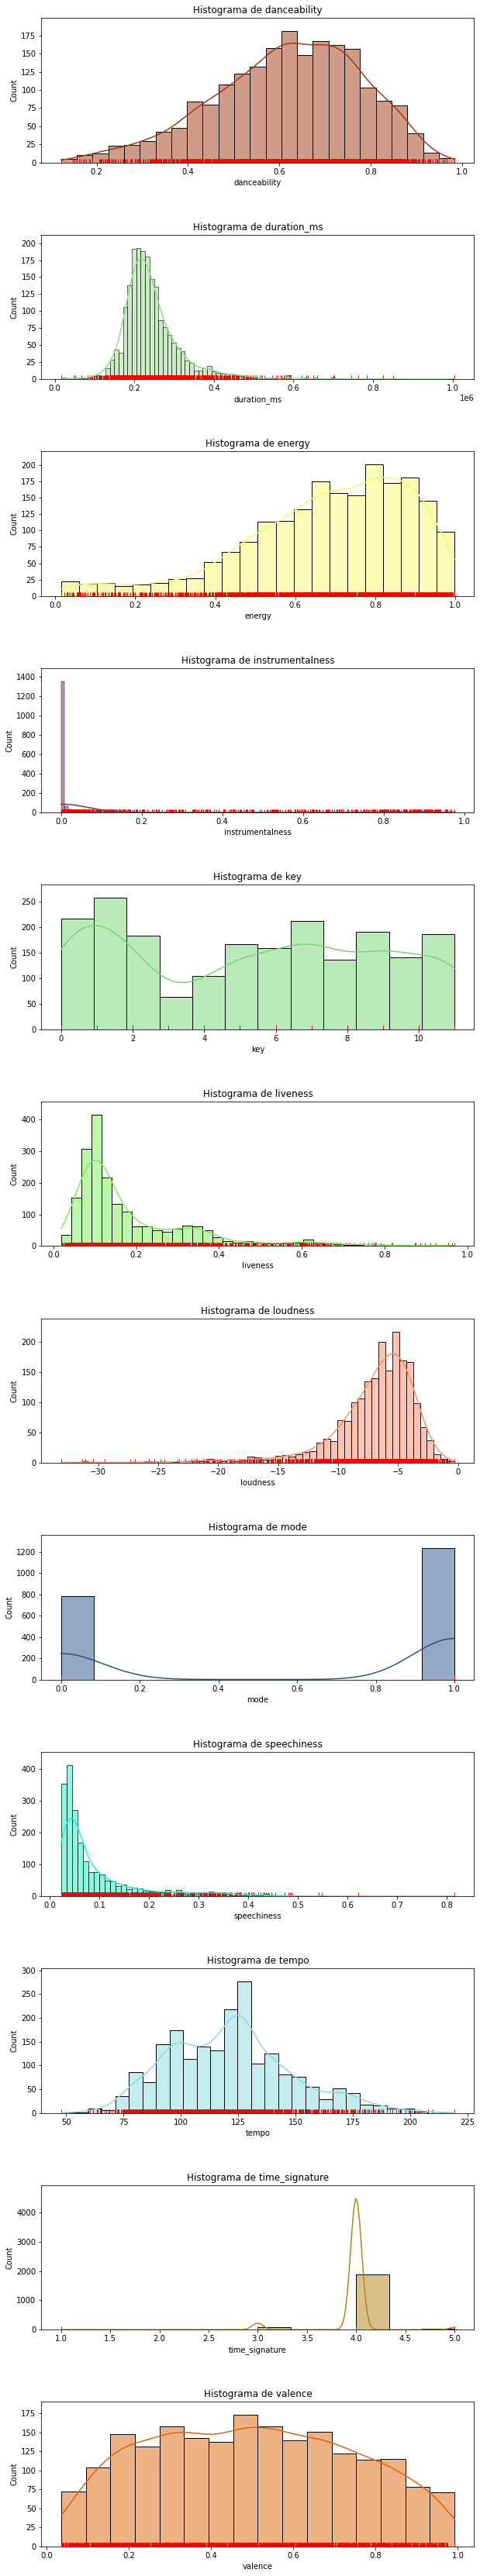

In [53]:
plot_histograms(X,X.shape[1],1,10,60)

Para chequear cuáles variables podemos considerar como normales y cuales no, realizamos el test de hipotesis para cada variable, considerando como hipotesis verdadera el echo de que la distribución es normal.

In [54]:
from scipy.stats import stats

def test_result(p,df):
  alpha = [0.001,0.01,0.05,0.1]
  for i in range (len(alpha)):
    if p < alpha[i]:
        return i
  return -1
def check_distribution(df):  
  for f in df.columns:
    k2, p = stats.normaltest(df[f])
    isnormal = test_result(p,df)
    if(isnormal == 0):
      print("Hay extremadamente fuerte evidencia para asegurar que la variable casos "+f+" no es normal")
    elif( isnormal == 1):
      print("Hay muy fuerte evidencia para asegurar que la variable de casos "+f+" no es normal")
    elif(isnormal == 2):
      print("Hay fuerte evidencia para asegurar que la variable de casos "+f+" no es normal")
    elif(isnormal == 3):
      print("Hay alguna evidencia para asegurar que la variable de casos "+f+" no es normal")
    elif (isnormal == -1):
      text = "La variable casos "+f+" se puede considerar normal con un "
      interval = round((1-p)*100,2)
      text+=str(interval)
      text+="% de confianza.\n"
      text+=f"Con media = {df[f].mean():.3f}"
      text+=f" y desvío estandar = {df[f].std(ddof=1):.3f}"
      print(text)

In [55]:
check_distribution(X)

Hay extremadamente fuerte evidencia para asegurar que la variable casos danceability no es normal
Hay extremadamente fuerte evidencia para asegurar que la variable casos duration_ms no es normal
Hay extremadamente fuerte evidencia para asegurar que la variable casos energy no es normal
Hay extremadamente fuerte evidencia para asegurar que la variable casos instrumentalness no es normal
Hay extremadamente fuerte evidencia para asegurar que la variable casos key no es normal
Hay extremadamente fuerte evidencia para asegurar que la variable casos liveness no es normal
Hay extremadamente fuerte evidencia para asegurar que la variable casos loudness no es normal
Hay extremadamente fuerte evidencia para asegurar que la variable casos mode no es normal
Hay extremadamente fuerte evidencia para asegurar que la variable casos speechiness no es normal
Hay extremadamente fuerte evidencia para asegurar que la variable casos tempo no es normal
Hay extremadamente fuerte evidencia para asegurar que la

Para todas las variables del dataset hay extremadamente fuerte evidencia para asegurar que no son normales, por lo tanto, para poder curar los datos debemos normalizar estar variables de modo tal que las escalas de cada variable no generen sesgo en el modelo. La variable mode, al ser binaria, no es necesario normalizarla.

In [56]:
def get_normal(variable):
  variable = variable/variable.max()
  return variable

for var in X.columns:
    if var != 'mode':
      X[var] = get_normal(X[var])

print(X)


      danceability  duration_ms    energy  instrumentalness       key  \
0         0.846545     0.203658  0.434870          0.022439  0.181818   
1         0.755081     0.325427  0.359719          0.006260  0.090909   
2         0.851626     0.184852  0.412826          0.000240  0.181818   
3         0.502033     0.198495  0.338677          0.522541  0.454545   
4         0.689024     0.391083  0.562124          0.524590  0.454545   
...            ...          ...       ...               ...       ...   
2012      0.593496     0.273140  0.933868          0.002756  0.090909   
2013      0.908537     0.181343  0.893788          0.001711  0.090909   
2014      0.647358     0.206246  0.936874          0.004088  0.000000   
2015      0.566057     0.184745  0.993988          0.693648  0.090909   
2016      0.453252     0.203578  0.916834          0.000040  0.818182   

      liveness   loudness  mode  speechiness     tempo  time_signature  \
0     0.170279  28.648208     1     0.528186  0.6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Fitting 5 folds for each of 43 candidates, totalling 215 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.564 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.547 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.531 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.563 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.638 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.584 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.572 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.511 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.576 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.598 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.601 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3

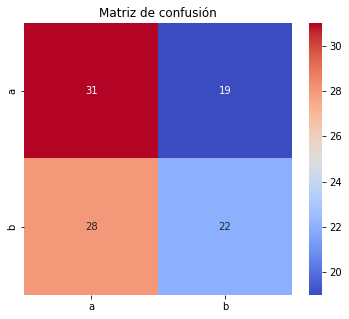

-----------------------------------------------------------------
TP: 31 	FP: 28 	TN: 22 	FN: 19
accuracy: 0.53
precision: 0.525
sensitivity: 0.62
specificity: 0.44
f_measure: 0.569
indice Jaccard: 0.397
-----------------------------------------------------------------


In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
k_range = list(range(1, int(np.sqrt(X.shape[0]))))
param_grid = dict(n_neighbors=k_range)
  
grid = GridSearchCV(knn, param_grid, cv=splits, scoring='accuracy', return_train_score=False,verbose=3)
grid_search=grid.fit(X, y)

k = grid_search.best_params_['n_neighbors']
knn_model = KNeighborsClassifier(k)
exactitud = round(grid_search.best_score_,4)
print('La exactitud del mejor modelo es de  ',exactitud," con ",k," vecinos mas cercanos.")

matriz_confusion=get_confusion_matrix(y_test,label_pred)

model_params = get_model_params(matriz_confusion)
print_model_params(model_params)

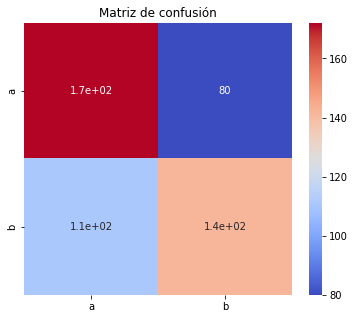

-----------------------------------------------------------------
TP: 172 	FP: 111 	TN: 142 	FN: 80
accuracy: 0.622
precision: 0.608
sensitivity: 0.683
specificity: 0.561
f_measure: 0.643
indice Jaccard: 0.474
-----------------------------------------------------------------


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 


random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
train_folds, test_folds = [],[]

clf = neighbors.KNeighborsClassifier(k)
clf.fit(X_train, y_train)
label_pred = clf.predict(X_test)
matriz_confusion=get_confusion_matrix(y_test,label_pred)
model_params = get_model_params(matriz_confusion)
models.append({"knn":knn_clas,"matriz confusion":matriz_confusion,"params": model_params})
print_model_params(model_params)



Si bien el modelo tiene unas métricas que estan por encima de un clasificador aleatorio no resulta ser un clasificador con un accuracy alto. Por lo tanto, vamos a intentar mejorar el modelo agregando la variable "artist" cuantificando sus registros.

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


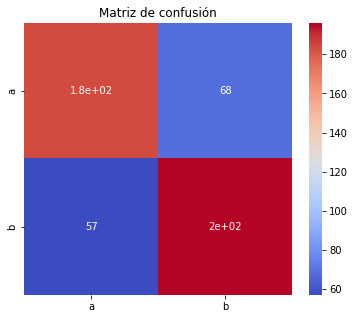

-----------------------------------------------------------------
TP: 184 	FP: 57 	TN: 196 	FN: 68
accuracy: 0.752
precision: 0.763
sensitivity: 0.73
specificity: 0.775
f_measure: 0.746
indice Jaccard: 0.595
-----------------------------------------------------------------


In [78]:
X = attributes_spotify[attributes_spotify.columns.drop(['target','song_title'])]
X.artist = pd.factorize(X['artist'])[0]
y = attributes_spotify[attributes_spotify.columns[13]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 


random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
train_folds, test_folds = [],[]

clf = neighbors.KNeighborsClassifier(k)
clf.fit(X_train, y_train)
label_pred = clf.predict(X_test)
matriz_confusion=get_confusion_matrix(y_test,label_pred)
model_params = get_model_params(matriz_confusion)
models.append({"knn":knn_clas,"matriz confusion":matriz_confusion,"params": model_params})
print_model_params(model_params)


Se puede observar, luego de agregar la variable 'artist' y sus correspondientes registros factorizados al dataset de entrenamiento que los parametros del modelo mejoraron. Observando los parametros obtenidos del modelo y considerando que la exactitud está en torno al 75% podemos decir que el clasificador puede resultar útil para predecir si una canción puede ser gustada o no. Para mejorar el modelo, se debería considerar más variables de entrada en la tabla, ya que, por ejemplo, no se sabe la hora del día en que la persona está escuchando la canción o el estado emocional, entre muchas otras.